Notebook done by:
- Name: Yashveer Singh
- email: yashveerm8@yahoo.com
- contact: 072 217 9781
- role: Senior Data Scientist

# Isazi Consulting AI Challenge

## Outline
Click on the link to be taken to the relevant section

- [1. Exploratory Data Analysis](#1)
    - [1.1. Loading and Exploring the Data](#1.1)
      - [Load Data](#Load)
      - [View the Dataset](#View)
      - [Analysis](#Analyze)
- [2. Modelling from Explored Data](#2)
    - [2.1. Transform Data for Model](#2.1)
    - [2.2. Create Daily Windowed Time Series Data & Model](#2.2)
      - [2.2.1. Windowing for basic Features](#2.2.1)
      - [2.2.2. Model Creation for basic Features](#2.2.2)
      - [2.2.3. Model Creation for Generated Features](#2.2.3)
      - [2.2.4. Running Predictions](#2.2.4)
    - [2.3. Close to Perfect Model](#2.3)
        - [Windowing for including Embeddings for Categorical Features](#window)
- [3. Conclusion](#3)
- [4. References](#4)

## Overview of this Notebook

- For the ISAZI AI challenge I have decided to create a Notebook that covers an end-to-end solution rather than optimizing for model performance.
- This notebook places much attention on the modelling section and setting up a Higly optimized data pipeline to run on a TPU and production environment.
- I have decided to do something **unique rather than building the standard timeseries models (ARIMA, SARIMA) that you can find in Kaggle Competion Notebooks** like the Uber Sigma competitions
- I have built a Multivariate-Multi Step Model Data Pipeline optimized to run on the TPU which I have not come across in any time series courses or the web


<a name='1'></a>
## 1. Exploratory Data Analysis

- The purpose of Exploratory Data Analysis is to gain insight into our dataset
- In Exploratory Data Analysis we:
    1. Examine the Distribution of our Data.
    2. Try to find new insights to our Data that will lead to better feature generation.
    3. This new feature generation will lead us to build a model with a higher performance score.
    4. Remember that Data Science is not about creating fancy plots of Data and fitting data to a model, but rather to gain insight from data that will lead to new features and increase overall model performance.
    5. In this notebook I have placed **massive emphasis** on the modelling section and optimization of the data pipeline which has been tested on a TPU for extreme performance rather than spending time on **EDA**
    6. A kaggle link has been provided on how I would have done EDA using wavelet denoising and ARIMA/moving averages

<a name='1.1'></a>
### 1.1 Loading and Exploring the data

<a name='Load'></a>
#### Load Data

First load the dataset which will be used for training and testing the model built in the modelling section.

In [1]:
!git clone https://github.com/maxbrent/IsaziChallenge.git

Cloning into 'IsaziChallenge'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 34 (delta 14), reused 18 (delta 5), pack-reused 0
Unpacking objects: 100% (34/34), done.


In [2]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from IPython.display import Image

In [3]:
pd.set_option("display.max_rows", None)

In [4]:
print(os.listdir("/content/IsaziChallenge"))

['DS - case study 1 - Sales task.pdf', 'models', 'reports', 'data', 'IsaziAIChallenge_Case_Study_1.ipynb', 'README.md', '.git']


In [5]:
sys.path.insert(0, '/content/IsaziChallenge/')

In [6]:
# from utils import load_data

data = pd.read_csv('/content/IsaziChallenge/data/DS - case study 1 - add material - sales_volumes.csv', index_col=0)

In [7]:
data.head()

,InvoiceID,ProductCode,Description,Volume,Date,UnitPrice
42481,539993,22386,JUMBO BAG PINK POLKADOT,29,2019-01-04 10:00:00,31.20
42482,539993,21499,BLUE POLKADOT WRAP,74,2019-01-04 10:00:00,6.72
42483,539993,21498,RED RETROSPOT WRAP,74,2019-01-04 10:00:00,6.72
42484,539993,22379,RECYCLING BAG RETROSPOT,14,2019-01-04 10:00:00,33.60
42485,539993,20718,RED RETROSPOT SHOPPER BAG,29,2019-01-04 10:00:00,20.00


In [8]:
len(data)

203422

In [9]:
data.dtypes

InvoiceID       object
ProductCode     object
Description     object
Volume           int64
Date            object
UnitPrice      float64
dtype: object

In [10]:
data.nunique()

InvoiceID      10770
ProductCode     3531
Description     3484
Volume           455
Date            9764
UnitPrice        966
dtype: int64

In [11]:
def convert_data_types(converted):
  """
    Converts data types to the relevant type
  
    Args:
      converted (dataframe): numpy array with data values.

    Returns:
      converted (dataframe): standardized and normalized numerical variables
  """
  converted['Date'] = pd.to_datetime(converted['Date'])
  converted['InvoiceID'] = converted['InvoiceID'].astype('category') 
  converted['ProductCode'] = converted['ProductCode'].astype('category') 
  converted['Description'] = converted['Description'].astype('category') 
  return converted

In [12]:
data = convert_data_types(data)

<a name='View'></a>
#### View the Dataset

The features (`data`) include the following fields:
* InvoiceID: (Categorical)
* ProductCode: (Categorical)
* Description: (Categorical)
* Volume: (Numeric) 
* UnitPrice: (Numeric) 

<a name='Analyze'></a>
#### Analysis
From the analysis above we can deduce:
- The data is a reasonable size to create a **windowed** dataset at various time points
- We have categorical & numerical variables
- There is **high cardinality** in each categorical variable
- The **Description** feature has multiple word correlations in which we can learn **Embeddings**
- We need to **scale** the numerical variables to remove outliers and data skewness

`data` is the Pandas DataFrames that holds the data for 203 , 422 records. 

<a name='2'></a>
## 2. Modelling
1. In this section we will create a Tensorflow **Multivariate Multi-Step Model**
2. We will train a model to predict the volume with **basic features**
3. We will train a model to predict the volume with **generated features** to evaluate change in performance
4. **Discussion** for how to build the Ideal Model for massive **improvement** unsing LSTM Embedding Encoder as the 1st Model and an LSTM Multivariate Multi-Step Model as the second model
5. Instead of focusing on **Moving Average models (SARIMA, ARIMA)** which we can easily find on Kaggle competitions, I have chosen to do something unique which I have not come across on the internet i.e. build a **Multivariate Multistep Model** for High Dimensional Data

**NB: My aim is to build a quick end-to-end solution rather than focusing on model performance given time constraints. My data pipeline code is Higly optimized to run on a TPU which I have tested on the Forex Markets with High Dimensional data**

<a name='2.1'></a>
### 2.1 Transform Data for Model

Copying Data to new variable and indexing datetime column
- Dropping Description Column because going to create separate embedding model

In [13]:
features = data.copy()
featuress = data.copy()

def drop_col(df, col_list):
  # df.set_index('Date',inplace=True)
  df.drop(col_list, axis=1, inplace=True)
  return df

In [14]:
features = drop_col(features, col_list=['Description'])
featuress = drop_col(featuress, col_list=['Description'])

In [15]:
features.head()

,InvoiceID,ProductCode,Volume,Date,UnitPrice
42481,539993,22386,29,2019-01-04 10:00:00,31.20
42482,539993,21499,74,2019-01-04 10:00:00,6.72
42483,539993,21498,74,2019-01-04 10:00:00,6.72
42484,539993,22379,14,2019-01-04 10:00:00,33.60
42485,539993,20718,29,2019-01-04 10:00:00,20.00


In [16]:
def basic_transform(ft): # When doing mean, the volume becomes positive, so have to use negative volume to identify discount and sum discounts for day as feature
  """
    Groups and averages dataframe by day. 
    Standardizes numerical feature values of data
  
    Args:
      ft (dataframe): dataframe with data values.

    Returns:
      ft_npy (numpy array): standardized and normalized numerical variables
  """
  ft = drop_col(ft, col_list=['InvoiceID', 'ProductCode'])
  ft = ft.groupby(pd.Grouper(key='Date',freq='D')).mean()
  ft = ft.fillna(0)
  ft = ft.values

  data_mean = ft[:, :2].mean(axis=0) # Not selecting the categorical features
  data_std = ft[:, :2].std(axis=0)

  ft_npy = (ft[:, :2]-data_mean)/data_std 

  return ft_npy

In [17]:
def generate_ft_transform(ft): # Takes into consideration discounts and returns
  """
    Groups and averages dataframe by day. 
    Standardizes numerical feature values of data
  
    Args:
      ft (dataframe): numpy array with data values.

    Returns:
      ft_npy (numpy array): standardized and normalized numerical variables
  """
  ft = drop_col(ft, col_list=['InvoiceID', 'ProductCode'])
  ft['IsReturns'] = ft['Volume'].apply(lambda x: 1 if x<0 else 0)
  ft['IsDiscount'] = ft['UnitPrice'].apply(lambda x: 1 if x==0 else 0)
  ft['IsWeekDay'] = ft.apply(lambda x: x["Date"].weekday(),axis=1)
  ft['IsWeekDay'] = (ft['IsWeekDay'] < 5).astype(int)
  # print(ft[((ft.Date.dt.month == 4)&(ft.Date.dt.year == 2019)&(ft.Date.dt.day == 1))&(ft.IsReturns==1)])
  # print(ft.dtypes)
  ft = ft.groupby(pd.Grouper(key='Date',freq='D')).agg(
      VolumeMean = pd.NamedAgg(column='Volume', aggfunc=np.mean),
      UnitPriceMean = pd.NamedAgg(column='UnitPrice', aggfunc=np.mean),
      TotReturns = pd.NamedAgg(column='IsReturns', aggfunc=np.sum),
      TotDiscount = pd.NamedAgg(column='IsDiscount', aggfunc=np.sum),
      TotWeekDays = pd.NamedAgg(column='IsWeekDay', aggfunc=np.sum)
  )
  ft = ft.fillna(0)
  ft = ft.values

  global mean_data 
  mean_data = ft[:, 0].mean(axis=0) # Used for converting predictions in the end
  global std_data 
  std_data = ft[:, 0].std(axis=0)

  global data_mean 
  data_mean = ft.mean(axis=0) # Not selecting the categorical features
  global data_std 
  data_std = ft.std(axis=0)

  ft_npy = (ft-data_mean)/data_std 

  return ft_npy

In [18]:
def transform_num_data(npy):
  """
    Standardizes and normalizes our numerical data in 
    our numpy array to remove the presence of outliers
  
    Args:
      npy (numpy array): numpy array with data values.

    Returns:
      npy (numpy array): standardized and normalized numerical variables
  """
  data_mean = npy[:, 3].mean(axis=0)                   # Selecting UnitPrice features
  data_std = npy[:, 3].std(axis=0)

  transform_unitP = (npy[:, 3] - data_mean) / data_std # We are standardizing the UnitPrice feature
  transform_volume = np.tanh(npy[:, 2])                # Normalize our Volume Data
 
  npy = np.hstack((np.reshape(npy[:, 0], (-1, 1)), np.reshape(npy[:, 1], (-1, 1)), np.reshape(transform_volume, (-1, 1)), np.reshape(transform_unitP, (-1, 1))))
  return npy

In [19]:
def transform_cat_data(ft):
  """
    Transforms data into label encoded values to use 
    for creating embeddings
  
    Args:
      ft (dataframe): unnormalized training data.

    Returns:
      ft (dateframe): label encoded categorical variables
  """
  encoder = LabelEncoder()
  ft['InvoiceID'] = encoder.fit_transform(ft['InvoiceID'])
  ft['ProductCode'] = encoder.fit_transform(ft['ProductCode'])
  # ft['Description'] = encoder.fit_transform(ft['Description']) Need to create a separate encoding embedding model for Description
  return ft

In [20]:
dataset = basic_transform(features)

In [21]:
datasett = generate_ft_transform(featuress)

In [22]:
print(dataset.shape)
print(datasett.shape)

(178, 2)
(178, 5)


In [23]:
# Print 1st 5 values of numpy array to compare to iterator
print(datasett[:5, :])

[[-0.26608458 -0.07434636 -0.0441942   0.5995467   0.61714245]
 [ 0.51515506  4.46338948  2.20339654 -0.22966319 -0.94672834]
 [ 0.85494172  0.09084604  1.64149885 -0.06382121 -0.94672834]
 [ 0.23400666 -0.16599746  0.1286974  -0.56134715  1.42285291]
 [-1.55193478 -0.95399623 -1.08154377 -0.56134715 -0.94672834]]


<a name='2.2'></a>
### 2.2 Create Daily Windowed Time Series Data & Model

<a name='2.2.1'></a>
#### 2.2.1 Windowing for basic Features

In [24]:
tf.random.set_seed(0)

In [25]:
# Window for Training Set. Data Pipeline optimized to run on TPU
def windowed_dataset_train(series, window_size, batch_size, shuffle_buffer, step_forecast):
    """
    Standardizes and normalizes our numerical data in 
    our numpy array to remove the presence of outliers
  
    Args:
      series (numpy array): numpy array with data values.
      window_size (integer): value for sliding window size.
      batch_size (integer): value to batch time windows.
      shuffle_buffer (integer): value to shuffle data from buffer.
      step_forecast (integer): value to forecast how many days ahead.

    Returns:
      ds (tensor): tensorflow tensor with sliding batched window and labels forecast
    """
    ds = tf.data.Dataset.from_tensor_slices(series) 
    ds = ds.window(window_size + step_forecast, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + step_forecast)).cache()       
    ds = ds.map(lambda w: (w[:-step_forecast], [w[i:i+step_forecast, 0]  for i in range(1, window_size+1)]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.shuffle(shuffle_buffer)  
    ds = ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [26]:
# Window for Validation Set
def windowed_dataset_valid(series, window_size, batch_size, shuffle_buffer, step_forecast):
    """
    Standardizes and normalizes our numerical data in 
    our numpy array to remove the presence of outliers
  
    Args:
      series (numpy array): numpy array with data values.
      window_size (integer): value for sliding window size.
      batch_size (integer): value to batch time windows.
      shuffle_buffer (integer): value to shuffle data from buffer.
      step_forecast (integer): value to forecast how many days ahead.

    Returns:
      ds (tensor): tensorflow tensor with sliding batched window and labels forecast
    """
    ds = tf.data.Dataset.from_tensor_slices(series) 
    ds = ds.window(window_size + step_forecast, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + step_forecast)).cache()       
    ds = ds.map(lambda w: (w[:-step_forecast], [w[i:i+step_forecast, 0]  for i in range(1, window_size+1)]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [27]:
preview_set = windowed_dataset_train(dataset, 10, 1, 60, 2) # 2 timesteps ahead with sliding window contain 10 samples, remove shuffle to preview window
train_set = windowed_dataset_train(dataset[:124, :], 44, 2, 60, 7)
valid_set = windowed_dataset_valid(dataset[124:178, :], 44, 2, 60, 7)
# train_set = windowed_dataset_train(dataset[:700000, :], 64, 1024, 1000, 10) # 100 timesteps ahead with 1st 700 000 of data
# valid_set = windowed_dataset_valid(dataset[700001:800000, :], 64, 1024, 1000, 10) # 100 timesteps ahead with last 260 000 of data
# test_set = windowed_dataset_test(dataset[800001:900000, :], 64, 1024, 1000, 10)

**Preview Sliding Windows**
- As you can see in the code cell below, we have a sample of 2 features in a daily sliding window of 10 days shown in the 1st array
- In the 2nd array we have a 2 step forecast
- The data that is previewed below seems like multiple labels in the 2nd array, however since we are getting the LSTM to predict a 2 step forecast at each timestep, we will have a 2-step forecast at each of the 10 steps in a slinding window of 10 steps
- The **actual windows** that will be **generated** will be a 62 day window, with a 31 day multi-step forecast at each timestep rather than the last timestep

In [ ]:
iterator = iter(preview)
print(next(iterator))

(<tf.Tensor: shape=(1, 10, 2), dtype=float64, numpy=
array([[[-2.66084583e-01, -7.43463584e-02],
        [ 5.15155062e-01,  4.46338948e+00],
        [ 8.54941721e-01,  9.08460432e-02],
        [ 2.34006664e-01, -1.65997464e-01],
        [-1.55193478e+00, -9.53996228e-01],
        [-1.41201471e-01, -1.90018046e-01],
        [-6.98642041e-01, -2.86152274e-04],
        [ 2.41860325e+00, -8.88144222e-02],
        [-4.88831291e-01,  5.75793395e-02],
        [-2.06740953e-01, -9.97170061e-03]]])>, <tf.Tensor: shape=(1, 10, 2), dtype=float64, numpy=
array([[[ 0.51515506,  0.85494172],
        [ 0.85494172,  0.23400666],
        [ 0.23400666, -1.55193478],
        [-1.55193478, -0.14120147],
        [-0.14120147, -0.69864204],
        [-0.69864204,  2.41860325],
        [ 2.41860325, -0.48883129],
        [-0.48883129, -0.20674095],
        [-0.20674095,  1.46673517],
        [ 1.46673517, -1.55193478]]])>)


<a name='2.2.2'></a>
#### 2.2.2 Model Creation for basic features
- Usually LSTM models are created just to predict values at the last time step.
- There is a major flaw with this, because it prevents the gradients from flowing through each timestep during back propagation causing instability.
- I will create an LSTM model to do a multi-step forecast at each timestep rather than just the last timestep

In [28]:
model = tf.keras.models.Sequential([
    # tf.keras.layers.Conv1D(filters=8, kernel_size=5,
    #                     strides=1, padding="causal",
    #                     activation="relu",
    #                     input_shape=[None, 2]),
    tf.keras.layers.LSTM(7, return_sequences=True, dropout=0.5, recurrent_dropout=0.5, input_shape=[None, 2]),
    # tf.keras.layers.Dense(31, activation="relu"), # is the same as applying a TimeDistributed Layer, the only reason we use TimeDistributed is for clarity to say that it is 
    # tf.keras.layers.Dense(31),
    
  ])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 7)           280       
Total params: 280
Trainable params: 280
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(train_set, epochs=10, validation_data=valid_set, callbacks=[lr_schedule])

Epoch 1/10
37/37 [==============================] - 1s 39ms/step - loss: 0.3871 - mae: 0.7342 - val_loss: 0.4760 - val_mae: 0.8022
Epoch 2/10
37/37 [==============================] - 1s 31ms/step - loss: 0.3877 - mae: 0.7352 - val_loss: 0.4760 - val_mae: 0.8022
Epoch 3/10
37/37 [==============================] - 1s 31ms/step - loss: 0.3879 - mae: 0.7356 - val_loss: 0.4760 - val_mae: 0.8022
Epoch 4/10
37/37 [==============================] - 1s 30ms/step - loss: 0.3872 - mae: 0.7349 - val_loss: 0.4760 - val_mae: 0.8022
Epoch 5/10
37/37 [==============================] - 1s 30ms/step - loss: 0.3873 - mae: 0.7345 - val_loss: 0.4760 - val_mae: 0.8022
Epoch 6/10
37/37 [==============================] - 1s 30ms/step - loss: 0.3875 - mae: 0.7346 - val_loss: 0.4760 - val_mae: 0.8022
Epoch 7/10
37/37 [==============================] - 1s 32ms/step - loss: 0.3878 - mae: 0.7353 - val_loss: 0.4760 - val_mae: 0.8022
Epoch 8/10
37/37 [==============================] - 1s 33ms/step - loss: 0.3874 - m

In [31]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae', 'lr'])

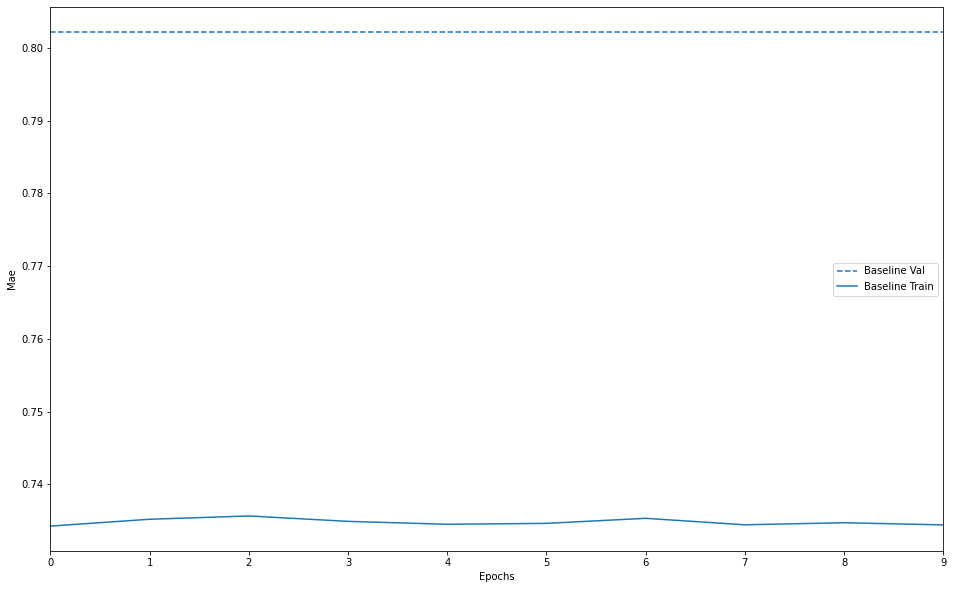

In [32]:
def plot_history(histories, key='mae'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history([('baseline', history)])

<a name='2.2.3'></a>
#### 2.2.3 Model Creation for Generated Features

In [33]:
train_sett = windowed_dataset_train(datasett[:124, :], 44, 2, 60, 7)
valid_sett = windowed_dataset_valid(datasett[124:178, :], 44, 2, 60, 7)

In [34]:
modell = tf.keras.models.Sequential([
    # tf.keras.layers.Conv1D(filters=8, kernel_size=5,
    #                     strides=1, padding="causal",
    #                     activation="relu",
    #                     input_shape=[None, 2]),
    tf.keras.layers.LSTM(7, return_sequences=True, dropout=0.5, recurrent_dropout=0.5, input_shape=[None, 5]),
    # tf.keras.layers.Dense(31, activation="relu"), # is the same as applying a TimeDistributed Layer, the only reason we use TimeDistributed is for clarity to say that it is 
    # tf.keras.layers.Dense(31),
    
  ])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
modell.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

In [35]:
modell.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 7)           364       
Total params: 364
Trainable params: 364
Non-trainable params: 0
_________________________________________________________________


In [36]:
historyy = modell.fit(train_sett, epochs=10, validation_data=valid_sett, callbacks=[lr_schedule])

Epoch 1/10
37/37 [==============================] - 1s 40ms/step - loss: 0.3944 - mae: 0.7460 - val_loss: 0.4891 - val_mae: 0.8252
Epoch 2/10
37/37 [==============================] - 1s 36ms/step - loss: 0.3943 - mae: 0.7462 - val_loss: 0.4891 - val_mae: 0.8252
Epoch 3/10
37/37 [==============================] - 1s 34ms/step - loss: 0.3950 - mae: 0.7477 - val_loss: 0.4891 - val_mae: 0.8252
Epoch 4/10
37/37 [==============================] - 1s 35ms/step - loss: 0.3948 - mae: 0.7468 - val_loss: 0.4891 - val_mae: 0.8252
Epoch 5/10
37/37 [==============================] - 1s 35ms/step - loss: 0.3947 - mae: 0.7468 - val_loss: 0.4891 - val_mae: 0.8252
Epoch 6/10
37/37 [==============================] - 1s 32ms/step - loss: 0.3939 - mae: 0.7458 - val_loss: 0.4891 - val_mae: 0.8252
Epoch 7/10
37/37 [==============================] - 1s 31ms/step - loss: 0.3948 - mae: 0.7468 - val_loss: 0.4891 - val_mae: 0.8252
Epoch 8/10
37/37 [==============================] - 1s 32ms/step - loss: 0.3948 - m

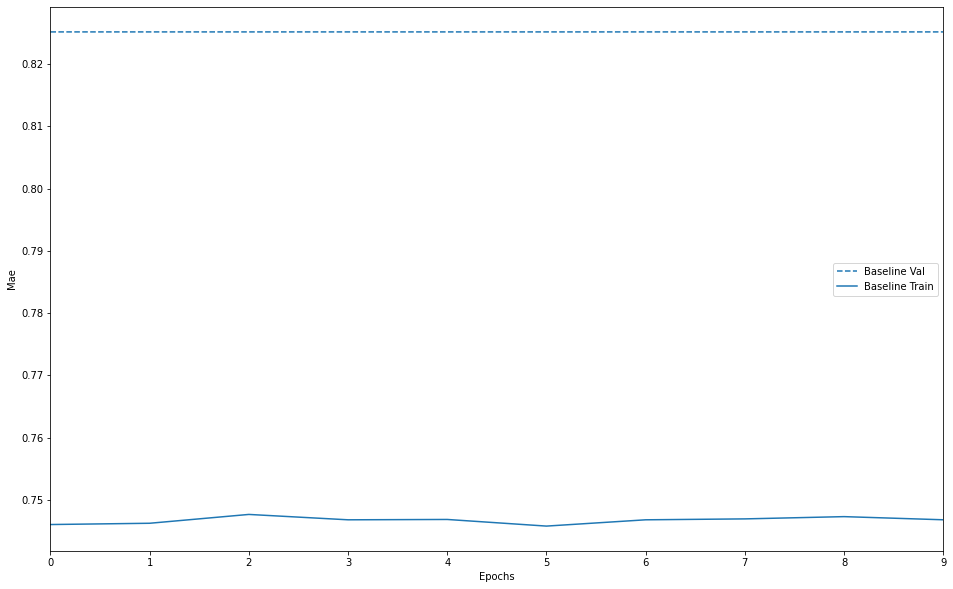

In [37]:
def plot_history(histories, key='mae'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history([('baseline', historyy)])

<a name='2.2.4'></a>
#### 2.2.4 Running Predicitions 

In [38]:
data.dtypes

InvoiceID            category
ProductCode          category
Description          category
Volume                  int64
Date           datetime64[ns]
UnitPrice             float64
dtype: object

In [39]:
print(len(data))

203422


In [40]:
def generate_predict_ft(ft): # Takes into consideration discounts and returns
  """
    Groups and averages dataframe by day. 
    Standardizes numerical feature values of data
  
    Args:
      ft (dataframe): numpy array with data values.

    Returns:
      ft_npy (numpy array): standardized and normalized numerical variables
  """
  ft = drop_col(ft, col_list=['InvoiceID', 'ProductCode'])
  ft['IsReturns'] = ft['Volume'].apply(lambda x: 1 if x<0 else 0)
  ft['IsDiscount'] = ft['UnitPrice'].apply(lambda x: 1 if x==0 else 0)
  ft['IsWeekDay'] = ft.apply(lambda x: x["Date"].weekday(),axis=1)
  ft['IsWeekDay'] = (ft['IsWeekDay'] < 5).astype(int)
  ft = ft.groupby(pd.Grouper(key='Date',freq='D')).agg(
      VolumeMean = pd.NamedAgg(column='Volume', aggfunc=np.mean),
      UnitPriceMean = pd.NamedAgg(column='UnitPrice', aggfunc=np.mean),
      TotReturns = pd.NamedAgg(column='IsReturns', aggfunc=np.sum),
      TotDiscount = pd.NamedAgg(column='IsDiscount', aggfunc=np.sum),
      TotWeekDays = pd.NamedAgg(column='IsWeekDay', aggfunc=np.sum)
  )
  ft = ft.fillna(0)
  ft = ft.values

  ft_npy = (ft-data_mean)/data_std 

  return ft_npy

In [41]:
def predict_transform(df_to_predict):
  # Might have to create a read csv to pass from command line
  convert_data_types(df_to_predict)
  fts = df_to_predict.copy()
  fts = drop_col(fts, col_list=['Description'])
  data_set = generate_predict_ft(fts)
  predict_set = windowed_dataset_valid(data_set, 44, 2, 60, 7)
  return predict_set

In [42]:
prediction_set = predict_transform(data.iloc[:-60000, :]) # Create an argument parser to parse prediction dataframe file through command line
npyz = (modell.predict(prediction_set) * std_data) + mean_data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [43]:
print(npyz[0, 0, :])
print(npyz[0, 1, :])
print(npyz[0, 2, :])

[22.040794 22.30324  23.162722 22.696892 22.49132  22.508926 23.424372]
[24.176308 17.695864 27.374987 23.159117 20.47332  24.464855 26.995945]
[22.31354  19.729282 25.651539 24.928905 22.528397 23.286797 24.758812]


<a name='2.3'></a>
### 2.3 Close to Perfect Model
- Thus far I have kept the model simple by building the first **Multivariate Multi-Step**  model with just the **Volume** and **UnitPrice** features
- The **second** model that was built was a result of generating more features such as **discounts, returns(negative volumes), weekends/weekdays**. We could also include exponential moving averages as features to improve performance
- The **IDEAL** way to build a model for the best performance is to do the following:
  1. Firstly there is a **massive correlation** for the **"Description"** feature, so we need to train an encoder to learn embeddings for the Description feature. I have written some sample code for this, however due to time constraints I am just explaining my thought process rather than building this complex model.
  2. Once we have **learnt the embeddings for the Description feature**, we can then train a **second model**, using the first model to generate embeddings for the Description feature.
  3. The second model will be the same as the model that I have built for the generated features, however this time I will include the **"ProductID"** and **"InvoiceID"** as embedding features. 

**NB: I have written sample code to show that I am capable of building this complex model, however the first 2 models are fully functional**

<a name='window'></a>
#### Windowing for including Embeddings for Categorical Features

In [ ]:
# Test Window
def windowed_dataset(series, window_size, batch_size, shuffle_buffer, step_forecast):
    ds = tf.data.Dataset.from_tensor_slices(({'input_x': series[:, 2:], 'input_embed': series[:, :-2].astype(int)})) 
    ds_all = ds.window(window_size + step_forecast, shift=1, drop_remainder=True)
    ds = ds_all.flat_map(lambda w: w['input_x'].batch(window_size + step_forecast))
                    
    ds = ds.map(lambda w: w[:-step_forecast])     
    ds = ds.batch(batch_size).prefetch(1) 

    ds2 = ds_all.flat_map(lambda w: w['input_embed'].batch(window_size + step_forecast))
                     
    ds2 = ds2.map(lambda w: w[:-step_forecast])      
    ds2 = ds2.batch(batch_size).prefetch(1) 

    ds3 = ds_all.flat_map(lambda w: w['input_x'].batch(window_size + step_forecast))
                     
    ds3 = ds3.map(lambda w: tf.stack([w[i:i+step_forecast, 0]  for i in range(1, window_size+1)], axis=0))     
    ds3 = ds3.batch(batch_size).prefetch(1) 

    # Both Methods Work
    ds_final = tf.data.Dataset.zip(({'input_main': ds, 'input_embed': ds2}, ds3)) 
    # ds_final = tf.data.Dataset.zip(((ds, ds2), ds3))

    return ds_final # iter(ds_final)

    # return ds, ds2, ds3

In [ ]:
iterator = iter(windowed_dataset(dataset, 20, 1, 1000, 5))

In [ ]:
train_set = next(iterator)

In [ ]:
print(train_set)

({'input_main': <tf.Tensor: shape=(1, 20, 2), dtype=float64, numpy=
array([[[ 1.        , -0.02575347],
        [ 1.        , -0.03921155],
        [ 1.        , -0.03921155],
        [ 1.        , -0.02443406],
        [ 1.        , -0.03191076],
        [ 1.        , -0.02575347],
        [ 1.        , -0.01431851],
        [ 1.        , -0.03015154],
        [ 1.        , -0.01695735],
        [ 1.        , -0.02575347],
        [ 1.        , -0.0204758 ],
        [ 1.        , -0.0204758 ],
        [ 1.        , -0.0204758 ],
        [ 1.        , -0.01695735],
        [ 1.        , -0.01695735],
        [ 1.        , -0.0204758 ],
        [ 1.        , -0.00552238],
        [-0.9993293 , -0.04290592],
        [-1.        , -0.04290592],
        [-1.        , -0.04290592]]])>, 'input_embed': <tf.Tensor: shape=(1, 20, 2), dtype=int64, numpy=
array([[[   0, 1270],
        [   0,  622],
        [   0,  621],
        [   0, 1263],
        [   0,  167],
        [   0, 3048],
        [  

<a name='3'></a>
## 3. Conclusion
- This is a notebook to get Data Scientists started and covers all of the necessary techniques 
- However due to my time constraints I could not include everything that I wanted to include
- So instead I have attached my unstructured notes on these topics in the github repository provided.
- This is located in the "Raw" folder in my github repository.
<br>
<br>
- For future use the following content will be added:
    - Evaluating Model Performance with Multiple Metrics(TP, TN, FP, FN, Precision, Recall, F1 Score, AUC, ROC)
    - Scaling our Models to Production in Google Cloud Platform
    - Advanced Statistics such as Gaussian Processes, Multivariate Distributions, Likelihood, Out-of-Distribution models, etc.

<a name='4'></a>
## 4. References

**[1] Géron, A., 2019. Hands-On Machine Learning With Scikit-Learn, Keras And Tensorflow. 2nd ed. Sebastopol: O'Reilly Media. [Book](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)**

**[2] [Tensorflow Timeseries Prediction Deeplearning.AI](https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction)**

**[3] [Kaggle M5 Competition Timeseries (DENOISING WAVELETS, ARIMA, MOVING AVERAGES)](https://www.kaggle.com/tarunpaparaju/m5-competition-eda-models)**